In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-whitegrid')

## for dataset
import urllib.request
import zipfile
import os

In [ ]:
movielens_url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
download_path = "/content/movielens"

os.makedirs(download_path, exist_ok=True)
zip_file_path = os.path.join(download_path, "ml-latest-small.zip")
urllib.request.urlretrieve(movielens_url, zip_file_path)

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
  zip_ref.extractall(download_path)

extracted_files = os.listdir(download_path)
print("Files in the extracted directory:", extracted_files)

Files in the extracted directory: ['ml-latest-small', 'ml-latest-small.zip']


In [ ]:
# Loading the dataframe
df = pd.read_csv('movielens/ml-latest-small/ratings.csv')

In [ ]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
df.shape

(100836, 4)

In [ ]:
df = df.drop(columns=['timestamp'])
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
user_ratings_pivot1 = df.pivot_table(index='userId', columns='movieId', values='rating')
user_ratings_pivot1.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#filling missing values by centralizing
user_ratings_pivot2 = user_ratings_pivot1.sub(user_ratings_pivot1.mean(axis=1), axis=0).fillna(0)
user_ratings_pivot2.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,0.0,-0.366379,0.0,0.0,-0.366379,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.363636,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
target_user = user_ratings_pivot2.iloc[[1]]
target_user

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
remove_movie_we_are_predicting = user_ratings_pivot2.drop( 1 , axis =1)
remove_movie_we_are_predicting.head()

movieId,2,3,4,5,6,7,8,9,10,11,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,-0.366379,0.0,0.0,-0.366379,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
users_watched_this_movie = user_ratings_pivot1[1]
df_filled_users_watched_thismovie = user_ratings_pivot2[users_watched_this_movie.notnull()]
df_filled_users_watched_thismovie.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,0.0,-0.366379,0.0,0.0,-0.366379,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.363636,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.269737,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,-0.948148,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.290476,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
users_watched_this_movie.dropna(inplace = True)
users_watched_this_movie.head()

userId
1     4.0
5     4.0
7     4.5
15    2.5
17    4.5
Name: 1, dtype: float64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
user_knn = KNeighborsRegressor(metric='cosine', n_neighbors=10)
user_knn.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred = user_knn.predict(target_user)
print(user_user_pred)

[3.55]


In [ ]:
user_knn2 = KNeighborsRegressor(metric='jaccard', n_neighbors=3)
user_knn2.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred2 = user_knn2.predict(target_user)
print(user_user_pred2)

[3.66666667]


In [ ]:
user_knn3 = KNeighborsRegressor(metric='euclidean', n_neighbors=3)
user_knn3.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred3 = user_knn3.predict(target_user)
print(user_user_pred3)

[3.]


In [ ]:
user_knn4 = KNeighborsRegressor(metric='manhattan', n_neighbors=3)
user_knn4.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred4 = user_knn4.predict(target_user)
print(user_user_pred4)

[3.33333333]


In [ ]:
user_ratings_pivot1

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
remove_movie_we_are_predicting = user_ratings_pivot2.drop( 1 , axis =1)
users_watched_this_movie = user_ratings_pivot1[1]
df_filled_users_watched_thismovie = user_ratings_pivot2[users_watched_this_movie.notnull()]
users_watched_this_movie.dropna(inplace = True)

split = int(0.8*df_filled_users_watched_thismovie.shape[0])

Xtrain = df_filled_users_watched_thismovie.iloc[:split-1].values
Ytrain = users_watched_this_movie[:split-1].values
Xtest = df_filled_users_watched_thismovie.iloc[split:].values
Ytest = users_watched_this_movie[split:].values

Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape

((171, 9724), (43, 9724), (171,), (43,))

In [ ]:
def similarity(metric , Xtrain, Ytrain, Xtest , k):
    user_knn = KNeighborsRegressor(metric= metric , n_neighbors=k)
    user_knn.fit(Xtrain, Ytrain)
    user_user_pred = user_knn.predict(Xtest)
    return user_user_pred

In [ ]:
best_k= None
best_error = 2
k_results =[]
for i in range(1,min(51, Xtrain.shape[0])):
    test_cosine = similarity('cosine', Xtrain, Ytrain, Xtest, i)
    evaluation = sklearn.metrics.mean_squared_error(Ytest, test_cosine)
    k_results.append(evaluation)
    print("The evaluation at k = "+ str(i) + " equals to "+ str(evaluation))
    if evaluation < best_error:
        best_k = i
        best_error = evaluation

print("---------------------Final Best result at K using cosine => " + str(best_k)+ "-------------------------------")

The evaluation at k = 1 equals to 0.7790697674418605
The evaluation at k = 2 equals to 0.6308139534883721
The evaluation at k = 3 equals to 0.518733850129199
The evaluation at k = 4 equals to 0.5018168604651163
The evaluation at k = 5 equals to 0.4546511627906976
The evaluation at k = 6 equals to 0.45041989664082693
The evaluation at k = 7 equals to 0.48599905078310396
The evaluation at k = 8 equals to 0.4406795058139535
The evaluation at k = 9 equals to 0.4559287970140682
The evaluation at k = 10 equals to 0.42889534883720937
The evaluation at k = 11 equals to 0.43028060734191814
The evaluation at k = 12 equals to 0.42688145994832033
The evaluation at k = 13 equals to 0.42300811889362866
The evaluation at k = 14 equals to 0.41940555291884196
The evaluation at k = 15 equals to 0.43136950904392757
The evaluation at k = 16 equals to 0.4100654069767442
The evaluation at k = 17 equals to 0.4179005391486279
The evaluation at k = 18 equals to 0.4285278495549813
The evaluation at k = 19 equal

In [ ]:
best_k= None
best_error = 2
k_results =[]
for i in range(1,51):
    test_cosine = similarity('jaccard', Xtrain, Ytrain, Xtest, i)
    evaluation = sklearn.metrics.mean_squared_error(Ytest, test_cosine)
    k_results.append(evaluation)
    print("The evaluation at k = "+ str(i) + " equals to "+ str(evaluation))
    if evaluation < best_error:
        best_k = i
        best_error = evaluation

print("---------------------Final Best result at K using jaccard => " + str(best_k)+ "-------------------------------")

The evaluation at k = 1 equals to 0.9767441860465116
The evaluation at k = 2 equals to 0.6686046511627907
The evaluation at k = 3 equals to 0.5813953488372093
The evaluation at k = 4 equals to 0.534156976744186
The evaluation at k = 5 equals to 0.6016279069767442
The evaluation at k = 6 equals to 0.610142118863049
The evaluation at k = 7 equals to 0.6249406739439962
The evaluation at k = 8 equals to 0.6237281976744186
The evaluation at k = 9 equals to 0.6268303186907838
The evaluation at k = 10 equals to 0.634593023255814
The evaluation at k = 11 equals to 0.6373246204113012
The evaluation at k = 12 equals to 0.6367894056847546
The evaluation at k = 13 equals to 0.6320696298334939
The evaluation at k = 14 equals to 0.6139060275272901
The evaluation at k = 15 equals to 0.614780361757106
The evaluation at k = 16 equals to 0.5970884811046512
The evaluation at k = 17 equals to 0.610424881306832
The evaluation at k = 18 equals to 0.6063917599770313
The evaluation at k = 19 equals to 0.61618

In [ ]:
best_k= None
best_error = 2
k_results =[]
for i in range(1,51):
    test_cosine = similarity('euclidean', Xtrain, Ytrain, Xtest, i)
    evaluation = sklearn.metrics.mean_squared_error(Ytest, test_cosine)
    k_results.append(evaluation)
    print("The evaluation at k = "+ str(i) + " equals to "+ str(evaluation))
    if evaluation < best_error:
        best_k = i
        best_error = evaluation

print("---------------------Final Best result at K using euclidean => " + str(best_k)+ "-------------------------------")

The evaluation at k = 1 equals to 0.8023255813953488
The evaluation at k = 2 equals to 0.815406976744186
The evaluation at k = 3 equals to 0.6802325581395349
The evaluation at k = 4 equals to 0.4382267441860465
The evaluation at k = 5 equals to 0.37511627906976736
The evaluation at k = 6 equals to 0.4018087855297157
The evaluation at k = 7 equals to 0.42821547223540574
The evaluation at k = 8 equals to 0.4366824127906977
The evaluation at k = 9 equals to 0.43776916451335046
The evaluation at k = 10 equals to 0.463139534883721
The evaluation at k = 11 equals to 0.48774745339227366
The evaluation at k = 12 equals to 0.5112645348837209
The evaluation at k = 13 equals to 0.5244598871611394
The evaluation at k = 14 equals to 0.5427740863787375
The evaluation at k = 15 equals to 0.5517054263565893
The evaluation at k = 16 equals to 0.5530069040697675
The evaluation at k = 17 equals to 0.5669912287760521
The evaluation at k = 18 equals to 0.5565963250071776
The evaluation at k = 19 equals to 

In [ ]:
best_k= None
best_error = 2
k_results =[]
for i in range(1,51):
    test_cosine = similarity('manhattan', Xtrain, Ytrain, Xtest, i)
    evaluation = sklearn.metrics.mean_squared_error(Ytest, test_cosine)
    k_results.append(evaluation)
    print("The evaluation at k = "+ str(i) + " equals to "+ str(evaluation))
    if evaluation < best_error:
        best_k = i
        best_error = evaluation

print("---------------------Final Best result at K using manhattan => " + str(best_k)+ "-------------------------------")

The evaluation at k = 1 equals to 0.9651162790697675
The evaluation at k = 2 equals to 0.8226744186046512
The evaluation at k = 3 equals to 0.618217054263566
The evaluation at k = 4 equals to 0.3851744186046512
The evaluation at k = 5 equals to 0.37465116279069766
The evaluation at k = 6 equals to 0.38388242894056845
The evaluation at k = 7 equals to 0.41338395823445667
The evaluation at k = 8 equals to 0.45566860465116277
The evaluation at k = 9 equals to 0.4777490668963536
The evaluation at k = 10 equals to 0.5108720930232559
The evaluation at k = 11 equals to 0.5367576398231789
The evaluation at k = 12 equals to 0.5584625322997417
The evaluation at k = 13 equals to 0.5746525388743635
The evaluation at k = 14 equals to 0.566652823920266
The evaluation at k = 15 equals to 0.5631007751937985
The evaluation at k = 16 equals to 0.5616597020348837
The evaluation at k = 17 equals to 0.5611169228293231
The evaluation at k = 18 equals to 0.5575294286534596
The evaluation at k = 19 equals to 

In [ ]:
from scipy.spatial.distance import correlation
best_k= None
best_error = 2
k_results =[]
for i in range(1,51):
    test_cosine = similarity(correlation, Xtrain, Ytrain, Xtest, i)
    evaluation = sklearn.metrics.mean_squared_error(Ytest, test_cosine)
    k_results.append(evaluation)
    print("The evaluation at k = "+ str(i) + " equals to "+ str(evaluation))
    if evaluation < best_error:
        best_k = i
        best_error = evaluation

print("---------------------Final Best result at K using pearson correlation => " + str(best_k)+ "-------------------------------")

The evaluation at k = 1 equals to 0.7790697674418605
The evaluation at k = 2 equals to 0.6308139534883721
The evaluation at k = 3 equals to 0.518733850129199
The evaluation at k = 4 equals to 0.5018168604651163
The evaluation at k = 5 equals to 0.4546511627906976
The evaluation at k = 6 equals to 0.45041989664082693
The evaluation at k = 7 equals to 0.48599905078310396
The evaluation at k = 8 equals to 0.4406795058139535
The evaluation at k = 9 equals to 0.4559287970140682
The evaluation at k = 10 equals to 0.42889534883720937
The evaluation at k = 11 equals to 0.43028060734191814
The evaluation at k = 12 equals to 0.42688145994832033
The evaluation at k = 13 equals to 0.42300811889362866
The evaluation at k = 14 equals to 0.41940555291884196
The evaluation at k = 15 equals to 0.43136950904392757
The evaluation at k = 16 equals to 0.4100654069767442
The evaluation at k = 17 equals to 0.4179005391486279
The evaluation at k = 18 equals to 0.4285278495549813
The evaluation at k = 19 equal

In [ ]:
from scipy.spatial.distance import correlation
test_cosine = similarity('cosine', Xtrain, Ytrain, Xtest, 34)
test_jaccard = similarity('jaccard', Xtrain, Ytrain, Xtest, 4)
test_euclidean = similarity('euclidean', Xtrain, Ytrain, Xtest, 5)
test_manhattan = similarity('manhattan', Xtrain, Ytrain, Xtest, 5)
test_pearson = similarity(correlation, Xtrain, Ytrain, Xtest, 34)

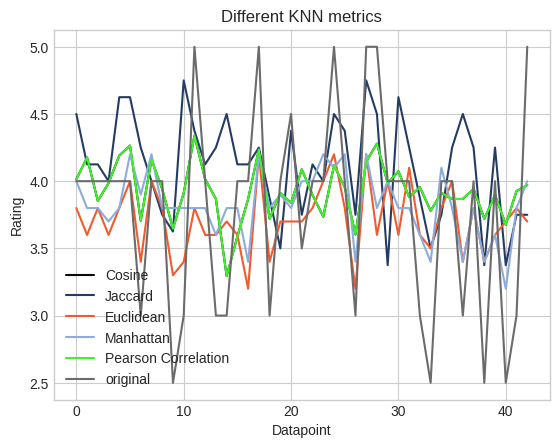

In [ ]:
plt.plot(test_cosine, label = "Cosine", color= '#0a0a0a')
plt.plot(test_jaccard, label = "Jaccard", color ='#243c63')
plt.plot(test_euclidean, label = "Euclidean", color ='#f15b2d')
plt.plot(test_manhattan, label = "Manhattan", color ='#8cacdc')
plt.plot(test_pearson, label = "Pearson Correlation", color ='#3ff22c')
plt.plot(Ytest, label = "original", color ='#6b6b6b')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Different KNN metrics')
plt.show()

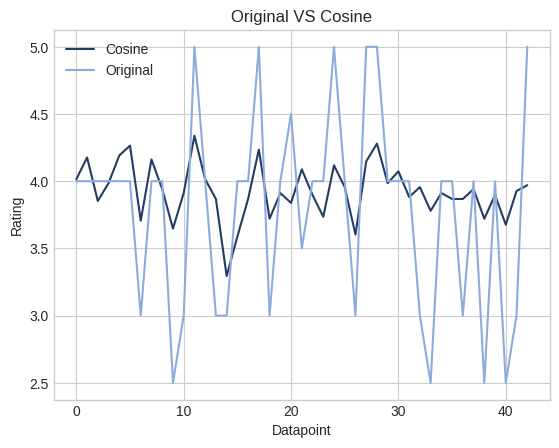

In [ ]:
plt.plot(test_cosine, label = "Cosine",color="#243c63")
plt.plot(Ytest, label = "Original", color ='#8cacdc')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Cosine')
plt.show()

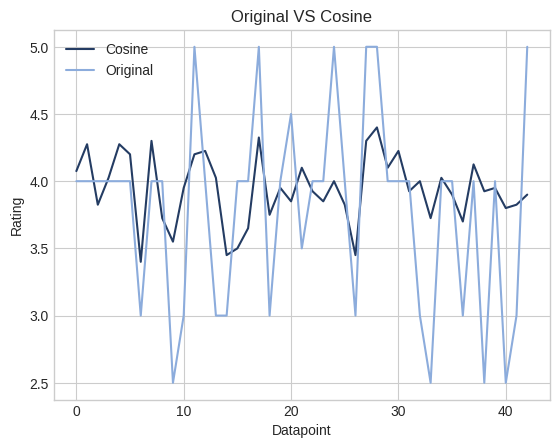

In [ ]:
test_cosine1 = similarity('cosine', Xtrain, Ytrain, Xtest, 20)
plt.plot(test_cosine1, label = "Cosine",color="#243c63")
plt.plot(Ytest, label = "Original", color ='#8cacdc')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Cosine')
plt.show()

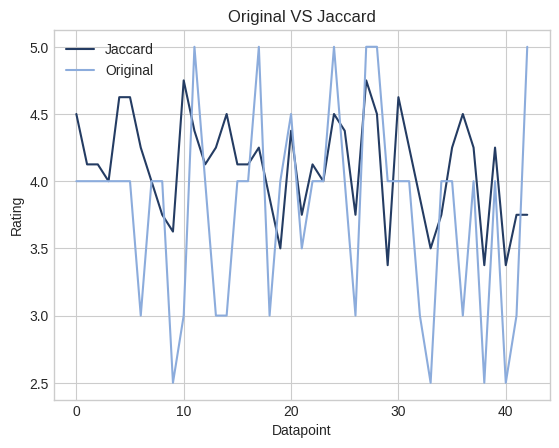

In [ ]:
plt.plot(test_jaccard, label = "Jaccard",color="#243c63")
plt.plot(Ytest, label = "Original", color ='#8cacdc')
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Jaccard')
plt.legend()
plt.show()

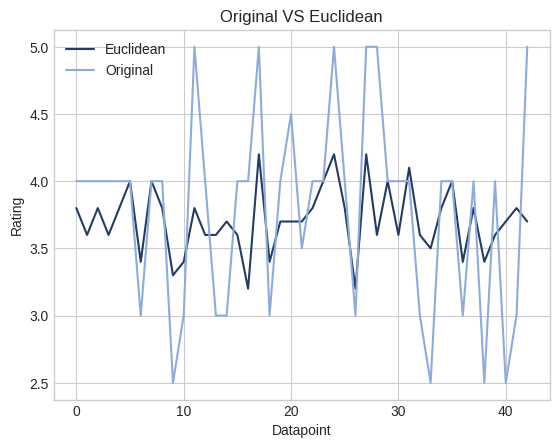

In [ ]:
plt.plot(test_euclidean, label = "Euclidean",color="#243c63")
plt.plot(Ytest, label = "Original", color ='#8cacdc')
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Euclidean')
plt.legend()
plt.show()

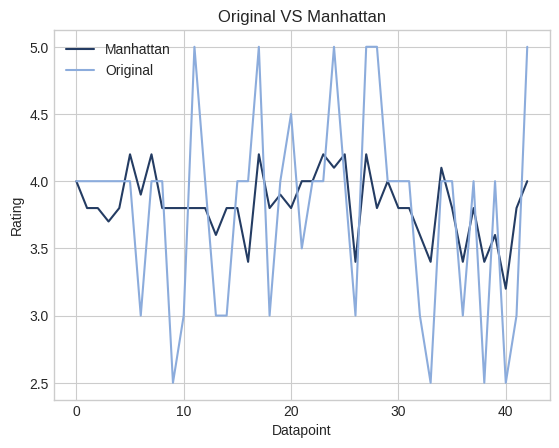

In [ ]:
plt.plot(test_manhattan, label = "Manhattan",color="#243c63")
plt.plot(Ytest, label = "Original", color ='#8cacdc')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Manhattan')
plt.show()

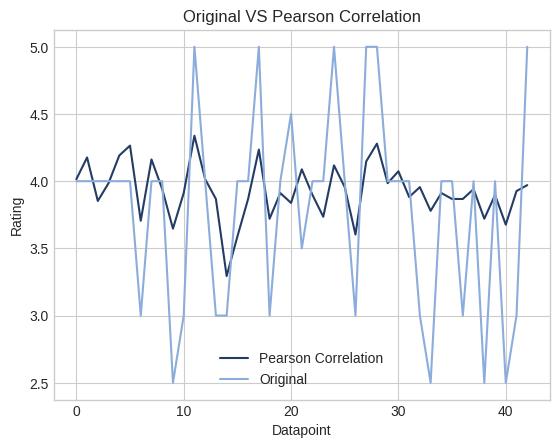

In [ ]:
plt.plot(test_pearson, label = "Pearson Correlation",color="#243c63")
plt.plot(Ytest, label = "Original", color ='#8cacdc')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Pearson Correlation')
plt.show()

In [ ]:
e_cosine =[sklearn.metrics.mean_squared_error(Ytest, test_cosine)]
e_jaccard=[sklearn.metrics.mean_squared_error(Ytest, test_jaccard)]
e_euclidean=[sklearn.metrics.mean_squared_error(Ytest, test_euclidean)]
e_manhattan =[sklearn.metrics.mean_squared_error(Ytest, test_manhattan)]
e_pearson =[sklearn.metrics.mean_squared_error(Ytest, test_pearson)]

In [ ]:
evaluation_df = pd.DataFrame( {
                "Cosine similarity" : e_cosine,
                "Jaccard similarity": e_jaccard,
                "Euclidean similarity": e_euclidean,
                "Manhattan similarity": e_manhattan,
                "Pearson correlation similarity": e_pearson},
                index=['RMSE']
)

evaluation_df

,Cosine similarity,Jaccard similarity,Euclidean similarity,Manhattan similarity,Pearson correlation similarity
RMSE,0.391179,0.534157,0.375116,0.374651,0.391179


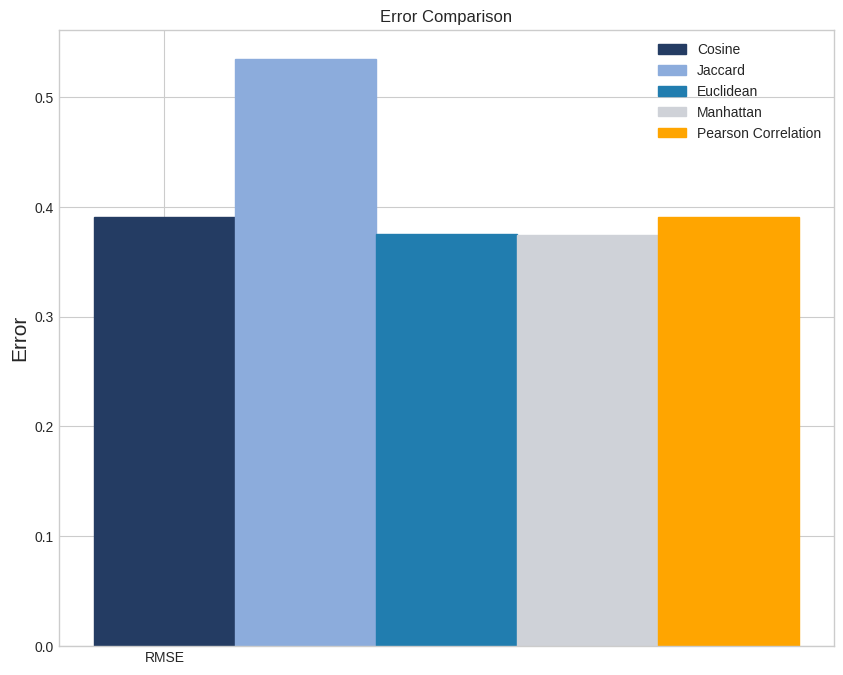

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.1
fig = plt.subplots(figsize =(10, 8))

# Set position of bar on X axis
br1 = np.arange(len(e_cosine))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br2, e_cosine, color ='#243c63', width = barWidth,
		edgecolor ='#243c63', label ='Cosine')
plt.bar(br3, e_jaccard, color ='#8cacdc', width = barWidth,
		edgecolor ='#8cacdc', label ='Jaccard')
plt.bar(br4, e_euclidean, color ='#217daf', width = barWidth,
		edgecolor ='#217daf', label ='Euclidean')
plt.bar(br5, e_manhattan, color ='#cfd2d8', width = barWidth,
		edgecolor ='#cfd2d8', label ='Manhattan')
plt.bar(br6, e_pearson, color ='orange', width = barWidth,
		edgecolor ='orange', label ='Pearson Correlation')

# Adding Xticks
plt.ylabel('Error', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(e_cosine))],
		['RMSE'])

plt.title('Error Comparison')
plt.legend()
plt.show()

In [ ]:
test_cosine = similarity('cosine', Xtrain, Ytrain, Xtest, 10)
test_jaccard = similarity('jaccard', Xtrain, Ytrain, Xtest, 10)
test_euclidean = similarity('euclidean', Xtrain, Ytrain, Xtest, 10)
test_manhattan = similarity('manhattan', Xtrain, Ytrain, Xtest, 10)
test_pearson = similarity(correlation, Xtrain, Ytrain, Xtest, 10)

In [ ]:
e_cosine =[sklearn.metrics.mean_squared_error(Ytest, test_cosine)]
e_jaccard=[sklearn.metrics.mean_squared_error(Ytest, test_jaccard)]
e_euclidean=[sklearn.metrics.mean_squared_error(Ytest, test_euclidean)]
e_manhattan =[sklearn.metrics.mean_squared_error(Ytest, test_manhattan)]
e_pearson =[sklearn.metrics.mean_squared_error(Ytest, test_pearson)]

In [ ]:
evaluation_df = pd.DataFrame( {
                "Cosine similarity" : e_cosine,
                "Jaccard similarity": e_jaccard,
                "Euclidean similarity": e_euclidean,
                "Manhattan similarity": e_manhattan,
                "Pearson correlation similarity": e_pearson},
                index=['RMSE']
)

evaluation_df

,Cosine similarity,Jaccard similarity,Euclidean similarity,Manhattan similarity,Pearson correlation similarity
RMSE,0.428895,0.634593,0.46314,0.510872,0.428895


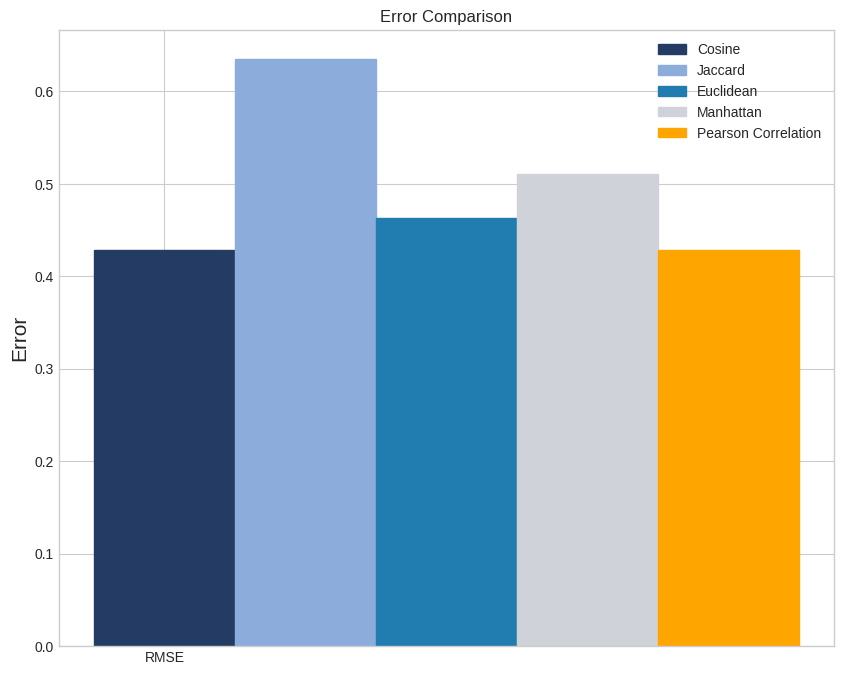

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.1
fig = plt.subplots(figsize =(10, 8))

# Set position of bar on X axis
br1 = np.arange(len(e_cosine))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br2, e_cosine, color ='#243c63', width = barWidth,
		edgecolor ='#243c63', label ='Cosine')
plt.bar(br3, e_jaccard, color ='#8cacdc', width = barWidth,
		edgecolor ='#8cacdc', label ='Jaccard')
plt.bar(br4, e_euclidean, color ='#217daf', width = barWidth,
		edgecolor ='#217daf', label ='Euclidean')
plt.bar(br5, e_manhattan, color ='#cfd2d8', width = barWidth,
		edgecolor ='#cfd2d8', label ='Manhattan')
plt.bar(br6, e_pearson, color ='orange', width = barWidth,
		edgecolor ='orange', label ='Pearson Correlation')

# Adding Xticks
plt.ylabel('Error', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(e_cosine))],
		['RMSE'])

plt.title('Error Comparison')
plt.legend()
plt.show()